In [26]:
!pip install lightgbm

In [2]:
# import libraries
import tensorflow as tf
print(tf.__version__)
from sklearn import datasets
from sklearn import preprocessing
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
from platform import python_version

2.8.0


In [3]:
df = pd.read_csv("_eir_dataset/thesis_data.csv")

In [4]:
print(df.head(5),"\n")

           Datetime   AG_MW      REGION
0  16-02-2022 00:00  4959.0  All Island
1  16-02-2022 00:15  4984.0  All Island
2  16-02-2022 00:30  5063.0  All Island
3  16-02-2022 00:45  5068.0  All Island
4  16-02-2022 01:00  5014.0  All Island 



In [5]:
# dropping the third column
df.drop(df.columns[2],axis=1,inplace=True)

In [6]:
print(df.head(5),"\n")

           Datetime   AG_MW
0  16-02-2022 00:00  4959.0
1  16-02-2022 00:15  4984.0
2  16-02-2022 00:30  5063.0
3  16-02-2022 00:45  5068.0
4  16-02-2022 01:00  5014.0 



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5672 entries, 0 to 5671
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  5672 non-null   object 
 1   AG_MW     5668 non-null   float64
dtypes: float64(1), object(1)
memory usage: 88.8+ KB


In [8]:
df.fillna(method ='pad',inplace=True)

In [9]:
df.isnull().sum()

Datetime    0
AG_MW       0
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AG_MW,5672.0,4784.528385,765.529136,2584.0,4175.0,4790.5,5343.0,6884.0


In [11]:
def AG_MW_demand(df, share_type='AG_MW', samples=250, period=96):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

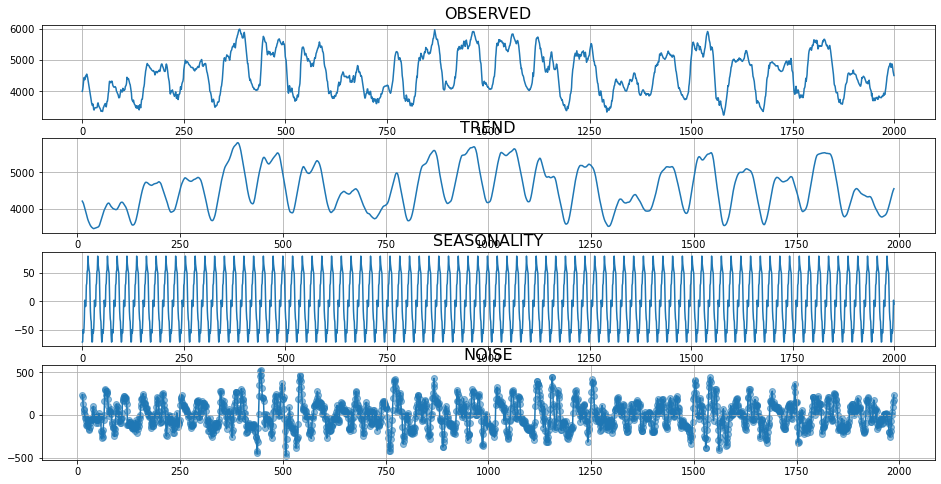

In [12]:
AG_MW_demand(df, samples=2000, period=24)

In [13]:
df.head()

,Datetime,AG_MW
0,16-02-2022 00:00,4959.0
1,16-02-2022 00:15,4984.0
2,16-02-2022 00:30,5063.0
3,16-02-2022 00:45,5068.0
4,16-02-2022 01:00,5014.0


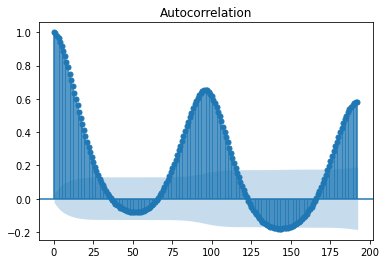

In [14]:
plot_acf(df['AG_MW'].values, lags=192)
plt.show()

In [15]:
'''
We’re going to use Microsoft’s Light Gradient Boosting Machine model.
This model was developed by Microsoft and it beats the standard Extreme Gradient Boosting (XGBoost)
in training speed and sometimes in accuracy.
Even though I use this machine learning model,
you can use whatever model you want within scikit-learn regressors or beyond.
'''

'\nWe’re going to use Microsoft’s Light Gradient Boosting Machine model.\nThis model was developed by Microsoft and it beats the standard Extreme Gradient Boosting (XGBoost)\nin training speed and sometimes in accuracy.\nEven though I use this machine learning model,\nyou can use whatever model you want within scikit-learn regressors or beyond.\n'

In [15]:
len(df)

5672

In [16]:
#convert datetime from object to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# #set datetime as index
# # df = df.set_index(df.datetime)
df = df.set_index('Datetime')

# #drop datetime column
# df.drop('Datetime', axis=1, inplace=True)

# #create hour, day and month variables from datetime index
# df['min'] = df.index.
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month

# #drop casual and registered columns
# df.drop(['casual', 'registered'], axis=1, inplace=True)

In [17]:
len(df)

5672

In [18]:
df.head()

,AG_MW,hour,day,month
Datetime,,,,
2022-02-16 00:00:00,4959.0,0,16,2
2022-02-16 00:15:00,4984.0,0,16,2
2022-02-16 00:30:00,5063.0,0,16,2
2022-02-16 00:45:00,5068.0,0,16,2
2022-02-16 01:00:00,5014.0,1,16,2


In [31]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [36]:
def train_time_series_with_folds(df, horizon=96*3):
    X = df.drop('AG_MW', axis=1)
    y = df['AG_MW']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Prediction ', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

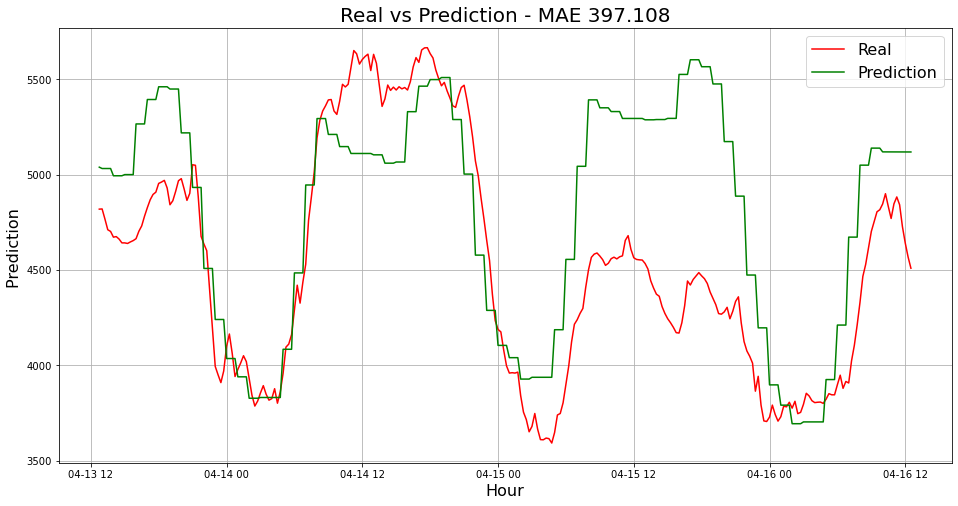

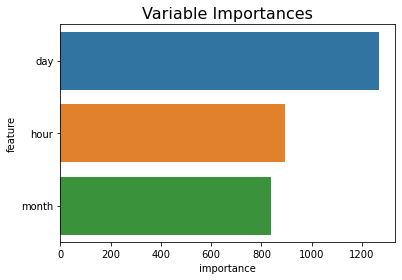

In [37]:
train_time_series_with_folds(df)

In [38]:
df['count_prev_week_same_hour'] = df['AG_MW'].shift(96*7)

#drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)

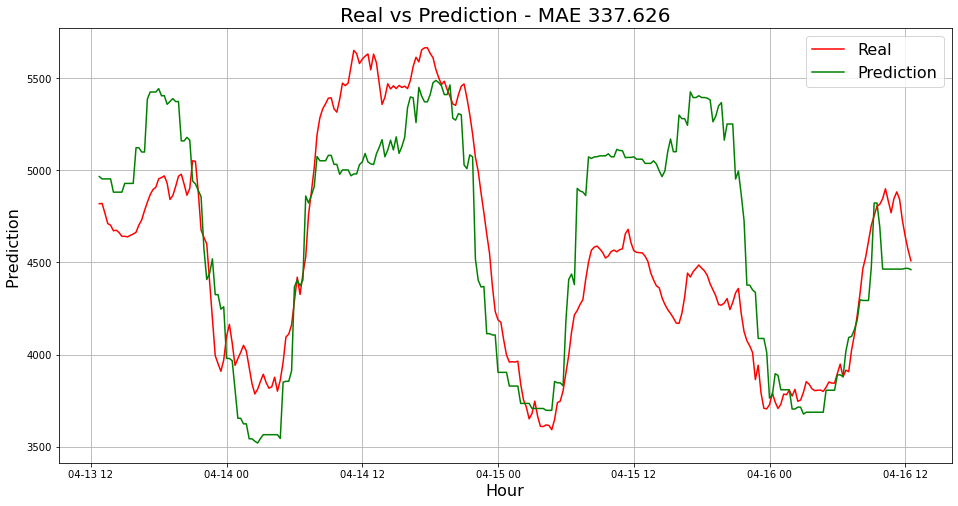

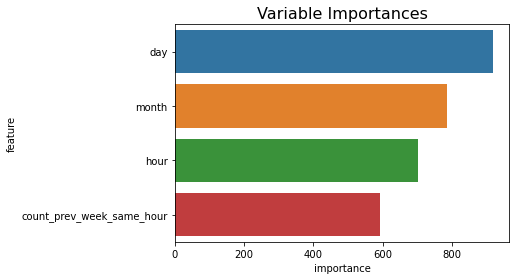

In [39]:
train_time_series_with_folds(df)